In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

In [2]:
meta = pd.read_csv('../adni_mri_dl/dirty_adni/metadata.csv')

mask = (meta.DX == 'Normal') | (meta.DX == 'AD')
norm = meta[mask].copy()
norm.DX = (norm.DX == 'Normal').astype(np.int)

# making fair division
norm = norm.groupby('patient').first().reset_index()

images, labels = norm.image_file.as_matrix(), np.array(norm.DX, dtype='int32')
patients = norm.patient.as_matrix()

In [3]:
from tqdm import tqdm

def load_compressed(images, prefix='/home/mount/neuro-t01-hdd/adni_unprocessed/', suffix='_compressed',
                    progress=False):
    result = np.zeros((len(images), 1, 96, 96, 80), dtype='float32')
    bar = enumerate(images)
    if progress:
        bar = tqdm(bar, total=len(images))
    for it, image in bar:
        data = np.load(prefix + 'ADNI' + suffix + image[20:] + '.npy')
        data /= data.max()
        result[it, 0, :, :, :] = data

    return result

def data_iterator():
    for image in tqdm(images):
        yield load_compressed([image])[0]

In [4]:
from saliency import get_saliency, sampler

In [5]:
outer_shape, inner_shape = (1, 14, 14, 14), (1, 8, 8, 8)
sample = sampler(data_iterator(), outer_shape, inner_shape, 50)

100%|██████████| 416/416 [03:23<00:00,  2.06it/s]


In [6]:
from lasagne.layers.dnn import Conv3DDNNLayer, Pool3DDNNLayer
import lasagne
from wrapper import Network


architecture = [
       dict(type='InputLayer', shape=(None, 1, 96, 96, 80)),
   ] + [
           dict(type=Conv3DDNNLayer, num_filters=32, filter_size=3),
           dict(type=Pool3DDNNLayer, pool_size=2),
       ] * 4 + [
       dict(type='DenseLayer', num_units=256),
       dict(type='DropoutLayer', p=0.5),
       dict(type='DenseLayer', num_units=64),
       dict(type='DropoutLayer', p=0.5),
       dict(type='DenseLayer', num_units=2, nonlinearity=lasagne.nonlinearities.softmax),
   ]

net = Network(layers=architecture).compiled()

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 980 Ti (CNMeM is disabled, cuDNN 5005)


In [7]:
fold = 3
net.load('../adni_mri_dl/dirty_adni/scalefliprotate/', str(fold))

In [8]:
source = load_compressed([images[0]])[0]

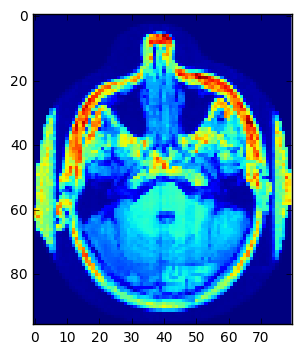

In [9]:
plt.imshow(source[0, 55], interpolation='none')

In [10]:
net.predict([source])

array([[  2.99445113e-09,   1.00000000e+00]], dtype=float32)

In [11]:
def network(x):
    p = net.predict(x)[:, 1]
#     laplace correction
    return  (p * len(images) + 1) / (len(images) + 2)

In [15]:
def draw(x, map):
    fig, axes = plt.subplots(1,3,sharey=True, figsize=(10,5.1))
    msk = np.ma.masked_where(map == 0, map)
    alpha = .6

    dx = 26
    axes[0].imshow(x[:, :, dx], cmap='gray')
    axes[0].imshow(msk[:, :, dx], alpha=alpha, cmap='viridis')

    dx = 40
    axes[1].imshow(x[:, dx], cmap='gray')
    att = axes[1].imshow(msk[:, dx], alpha=alpha, cmap='viridis')

    dx = 40
    axes[2].imshow(x[dx], cmap='gray')
    axes[2].imshow(msk[dx], alpha=alpha, cmap='viridis')

    plt.tight_layout(pad=0.1, w_pad=0.1, h_pad=.1)
    for ax in axes:
        ax.axis('off')

    plt.colorbar(att)

## No sampling

In [13]:
def simple_sampler(x, size):
    return np.zeros((size,) + inner_shape)

In [21]:
ss = get_saliency(network, source, outer_shape, inner_shape, 32, simple_sampler, 1, step=2, verbose=True)

55473it [09:16, 99.61it/s] 


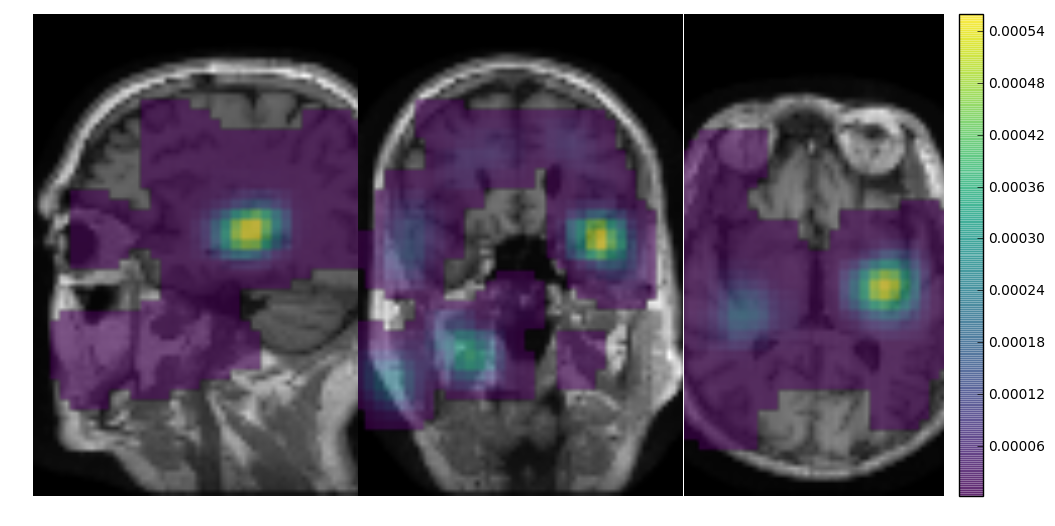

In [27]:
draw(source[0], ss[0])

## With sampling

In [24]:
sal = get_saliency(network, source, outer_shape, inner_shape, 32, sample, 10, step=3, verbose=True)

16038it [53:16,  6.06it/s]


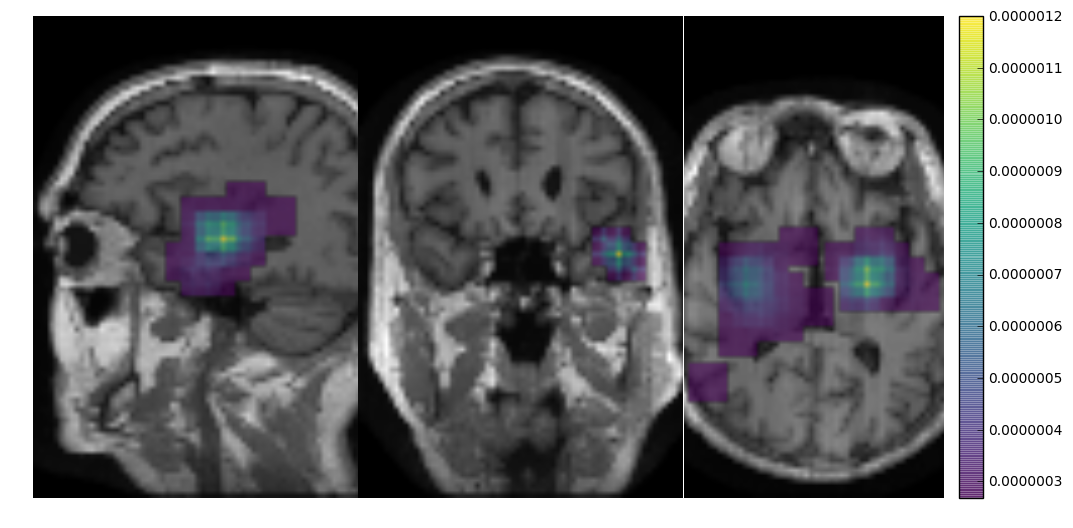

In [28]:
draw(source[0], sal[0])

In [16]:
batch_size = 32
num_samples = 10
step=2
verbose=True

In [14]:
def odds(x):
    return x / (1 - x)

begin = (np.array(outer_shape) - inner_shape) // 2
end = begin + inner_shape
coords = [slice(*i) for i in zip(begin, end)]

dims = np.array(source.shape) - outer_shape + 1
dims = dims // step
dims[dims == 0] = 1

probs = np.zeros(dims)
real = network([source])[0]

batch = []
indexes = []

# calculate the probabilities
bar = np.ndindex(*dims)
if verbose:
    bar = tqdm(bar)

0it [00:00, ?it/s]

In [17]:
for corner in bar:
    real_corner = np.array(corner) * step
    start = real_corner + begin
    idx = [slice(*i) for i in zip(start, start + inner_shape)]
    surround = [slice(*i) for i in zip(real_corner, real_corner + outer_shape)]
    surround = source[surround]

    for s in sample(surround, num_samples):
        temp = source.copy()
        temp[idx] = s
        batch.append(temp)
        indexes.append(corner)
        if len(batch) == batch_size:
            prob = network(batch)
            for key, value in zip(indexes, prob):
                probs[key] += value
            batch = []
            indexes = []

if batch:
    prob = network(batch)
    for key, value in zip(indexes, prob):
        probs[key] += value
probs /= num_samples

55473it [3:09:06,  4.84it/s]


In [18]:
cc = probs.copy()

In [23]:
# create the attention map
probs = np.log(odds(probs))
real = np.log(odds(real))
saliency = np.zeros_like(source)
counts = np.zeros_like(source)

In [24]:
for corner in np.ndindex(*dims):
    real_corner = np.array(corner) * step
    start = real_corner + begin
    idx = [slice(*i) for i in zip(start, start + inner_shape)]

    saliency[idx] += real - probs[corner]
    counts[idx] += 1

counts[counts == 0] = 1    

In [25]:
sal_sm = saliency / counts / np.log(2)

In [ ]:
sal_sm = get_saliency(network, source, outer_shape, inner_shape, 32, sample, 10, step=2, verbose=True)

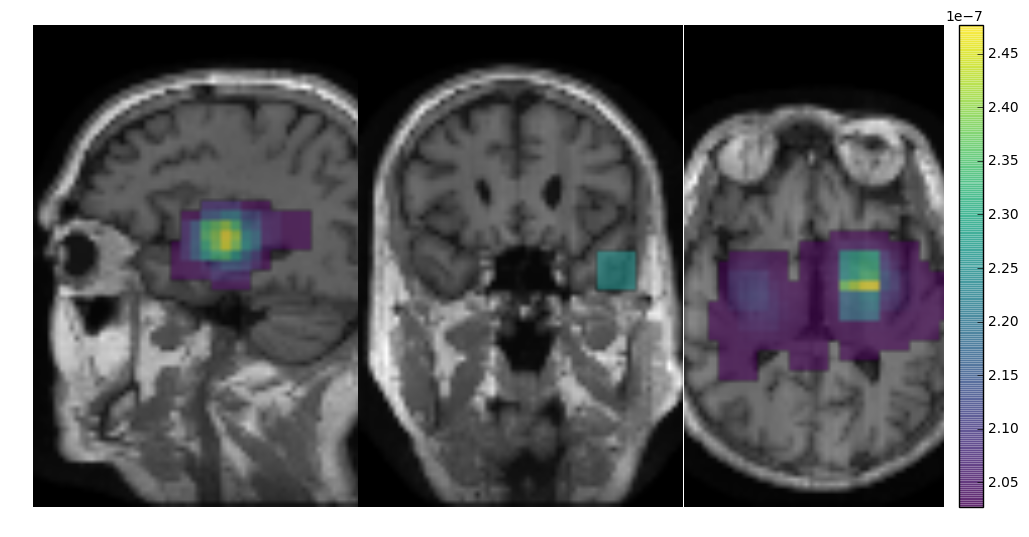

In [26]:
draw(source[0], sal_sm[0])